# A Cleaner approach to Bactesting strategy 3 - Renko and OBV 

In [8]:
import numpy as np
import pandas as pd
import datetime as dt
import copy 
import matplotlib.pyplot as plt

## Get data from Alpha Vantage 

In [5]:
tickers = ["AAPL","MSFT","INTC","INFY","TSLA","NVDA"]
ohlcv_data = get_data_from_alpha_vantage(tickers)
ohlcv_data["AAPL"]

,Open,High,Low,Close,Volume
date,,,,,
2024-06-18 19:55:00,214.020,214.090,214.01,214.020,13699.0
2024-06-18 19:50:00,214.050,214.090,214.00,214.030,7857.0
2024-06-18 19:45:00,214.050,214.110,214.03,214.066,2035.0
2024-06-18 19:40:00,214.127,214.127,214.03,214.070,1930.0
2024-06-18 19:35:00,214.120,214.130,214.05,214.080,3699.0
...,...,...,...,...,...
2024-05-21 04:20:00,190.840,190.870,190.78,190.850,3253.0
2024-05-21 04:15:00,190.920,190.920,190.80,190.800,710.0
2024-05-21 04:10:00,191.020,191.040,190.90,190.900,2683.0


In [317]:
ohlc_intraday = copy.deepcopy(ohlcv_data)

In [318]:
for ticker in ohlc_intraday:
    ohlc_intraday[ticker] = ohlc_intraday[ticker].between_time("09:35","16:00")
    ohlc_intraday[ticker] = ohlc_intraday[ticker][::-1]

In [233]:
print(ohlc_intraday["AAPL"])

                        Open     High     Low    Close      Volume
date                                                              
2024-05-21 09:35:00  191.503  191.820  191.39  191.770    642437.0
2024-05-21 09:40:00  191.750  191.970  191.61  191.965    674444.0
2024-05-21 09:45:00  191.965  191.965  191.66  191.805    685611.0
2024-05-21 09:50:00  191.805  191.880  191.53  191.851    432942.0
2024-05-21 09:55:00  191.855  192.240  191.81  192.200   1298316.0
...                      ...      ...     ...      ...         ...
2024-06-18 15:40:00  214.950  215.100  214.87  214.960    924593.0
2024-06-18 15:45:00  214.960  215.040  214.24  214.260    922439.0
2024-06-18 15:50:00  214.260  214.680  214.05  214.480   1723713.0
2024-06-18 15:55:00  214.480  214.480  213.91  214.380   2936934.0
2024-06-18 16:00:00  214.330  214.380  213.90  214.310  19855938.0

[1560 rows x 5 columns]


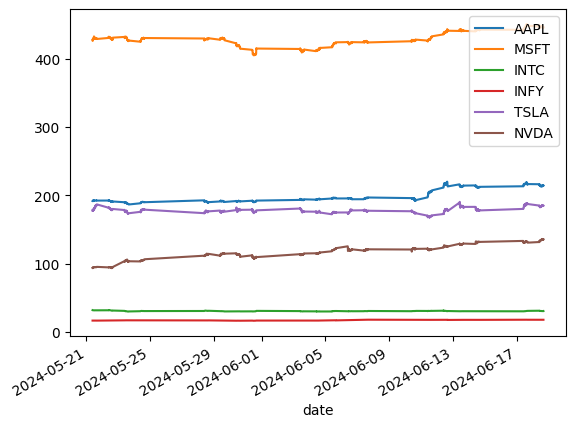

In [319]:
plt.figure()
for ticker,df in ohlc_intraday.items():
    df["Close"].plot()
plt.legend(tickers)

---

## Renko parameters 

In [320]:
class base:

    def ATR(DF, n, timescale):
        df = DF.copy()
        h_l = abs(df["High"] - df["Low"])
        h_pc = abs(df["High"] - df["Close"].shift(1))
        l_pc = abs(df["Low"] - df["Close"].shift(1))
        tr = pd.concat([h_l, h_pc, l_pc])#.max(axis = 1, skipna = False)
        atr = tr.rolling(n).mean() # n
        return atr 
        
    def CAGR(DF, timescale):
        df = DF.copy()
        cum_ret = (1+ df["ret"]).cumprod()
        n = len(df)/timescale
        cagr = (cum_ret.tolist()[-1])**(1/n) - 1
        return cagr 

    def volatility(DF, timescale):
        df = DF.copy()
        v = df["ret"].std() * np.sqrt(timescale)
        return v 

    def sharpe(DF, timescale, rf):
        cagr = base.CAGR(DF, timescale)
        v = base.volatility(DF, timescale)
        return (cage - rf)/v

    def max_dd(DF, timescale):
        "max drawdown"
        cum_ret = (1+df["ret"]).cumprod()
        cum_max = cum_ret.cummax()
        dd = (cum_max - cum_ret)/cum_max
        return dd.max() 


In [321]:
atr = base.ATR
df = ohlc_intraday["AAPL"]
atr(df, 120, 252*28)

date
2024-05-21 09:35:00         NaN
2024-05-21 09:40:00         NaN
2024-05-21 09:45:00         NaN
2024-05-21 09:50:00         NaN
2024-05-21 09:55:00         NaN
                         ...   
2024-06-18 15:40:00    0.229767
2024-06-18 15:45:00    0.235100
2024-06-18 15:50:00    0.236142
2024-06-18 15:55:00    0.238808
2024-06-18 16:00:00    0.240392
Length: 4680, dtype: float64

In [322]:
ticker = "AAPL"
df = ohlc_intraday[ticker].copy()
print(df.columns)

# renko df 
df.reset_index(inplace = True)
print(df.columns)
df.columns = ["date","open","high","low","close", "volume"]
renko = Renko(df)
atr_last_value = base.ATR(ohlc_intraday[ticker], 120, 252*78).iloc[-1]
print(atr_last_value)
renko.brick_size = max(0.5, round(atr_last_value, 0))
print(renko.brick_size)
renko = renko.get_ohlc_data()
print(renko)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Index(['date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
0.2403916666666653
0.5
                    date   open   high    low  close  uptrend
0    2024-05-21 09:35:00  191.0  191.5  191.0  191.5     True
1    2024-05-21 09:55:00  191.5  192.0  191.5  192.0     True
2    2024-05-21 11:05:00  192.0  192.5  192.0  192.5     True
3    2024-05-22 12:45:00  192.0  192.0  191.5  191.5    False
4    2024-05-22 13:40:00  191.5  191.5  191.0  191.0    False
..                   ...    ...    ...    ...    ...      ...
194  2024-06-18 09:55:00  215.5  215.5  215.0  215.0    False
195  2024-06-18 11:10:00  215.0  215.0  214.5  214.5    False
196  2024-06-18 11:15:00  214.5  214.5  214.0  214.0    False
197  2024-06-18 11:50:00  214.0  214.0  213.5  213.5    False
198  2024-06-18 15:15:00  214.0  214.5  214.0  214.5     True

[199 rows x 6 columns]


In [323]:
# bar_num cumsum

renko["bar_num1"] = pd.to_numeric(0 + renko["uptrend"])
renko["bar_num1"] = np.where(renko["bar_num1"] == 1, 1, -1).cumsum()
renko.drop_duplicates(subset = "date", keep = "last", inplace = True )
renko

,date,open,high,low,close,uptrend,bar_num1
0,2024-05-21 09:35:00,191.0,191.5,191.0,191.5,True,1
1,2024-05-21 09:55:00,191.5,192.0,191.5,192.0,True,2
2,2024-05-21 11:05:00,192.0,192.5,192.0,192.5,True,3
3,2024-05-22 12:45:00,192.0,192.0,191.5,191.5,False,2
4,2024-05-22 13:40:00,191.5,191.5,191.0,191.0,False,1
...,...,...,...,...,...,...,...
194,2024-06-18 09:55:00,215.5,215.5,215.0,215.0,False,49
195,2024-06-18 11:10:00,215.0,215.0,214.5,214.5,False,48
196,2024-06-18 11:15:00,214.5,214.5,214.0,214.0,False,47
197,2024-06-18 11:50:00,214.0,214.0,213.5,213.5,False,46


In [324]:
df["ret"] = renko["close"]/renko["close"].shift(1)
renko["obv"] = Robv.OBV(df)
renko

,date,open,high,low,close,uptrend,bar_num1,obv
0,2024-05-21 09:35:00,191.0,191.5,191.0,191.5,True,1,0.0
1,2024-05-21 09:55:00,191.5,192.0,191.5,192.0,True,2,674444.0
2,2024-05-21 11:05:00,192.0,192.5,192.0,192.5,True,3,1360055.0
3,2024-05-22 12:45:00,192.0,192.0,191.5,191.5,False,2,1792997.0
4,2024-05-22 13:40:00,191.5,191.5,191.0,191.0,False,1,3091313.0
...,...,...,...,...,...,...,...,...
194,2024-06-18 09:55:00,215.5,215.5,215.0,215.0,False,49,37848049.0
195,2024-06-18 11:10:00,215.0,215.0,214.5,214.5,False,48,38115841.0
196,2024-06-18 11:15:00,214.5,214.5,214.0,214.0,False,47,38439891.0
197,2024-06-18 11:50:00,214.0,214.0,213.5,213.5,False,46,38792994.0


In [336]:
renko["obv_slope"] = Robv.slope(renko["obv"],5)

[      0.  674444. 1360055. 1792997. 3091313.]
5 
 5
[ 674444. 1360055. 1792997. 3091313. 4344617.]
5 
 5
[1360055. 1792997. 3091313. 4344617. 4869714.]
5 
 5
[1792997. 3091313. 4344617. 4869714. 5405988.]
5 
 5
[3091313. 4344617. 4869714. 5405988. 5881667.]
5 
 5
[4344617. 4869714. 5405988. 5881667. 6376959.]
5 
 5
[4869714. 5405988. 5881667. 6376959. 6772306.]
5 
 5
[5405988. 5881667. 6376959. 6772306. 7188418.]
5 
 5
[5881667. 6376959. 6772306. 7188418. 7684067.]
5 
 5
[6376959. 6772306. 7188418. 7684067. 8146472.]
5 
 5
[6772306. 7188418. 7684067. 8146472. 8474661.]
5 
 5
[7188418. 7684067. 8146472. 8474661. 8759464.]
5 
 5
[7684067. 8146472. 8474661. 8759464. 9127548.]
5 
 5
[8146472. 8474661. 8759464. 9127548. 9664345.]
5 
 5
[ 8474661.  8759464.  9127548.  9664345. 10976363.]
5 
 5
[ 8759464.  9127548.  9664345. 10976363.]
4 
 5


ValueError: endog and exog matrices are different sizes

In [335]:
from stocktrends import Renko
import statsmodels.api as sm

class Robv(base):
    "Robv contains functions to calculate technical parameters and KPIs"

    def slope(ser, n):
        "function to calculate the slope of n consecutive slopes on a plot "
        slopes = [0]*(n-1) # why?
        for i in range(n, len(ser)):
            y = np.array(ser.loc[i-n:i-1])
            print(y)
            x = np.arange(n)
            y_scaled = (y - y.min())/(y.max() - y.min())
            x_scaled = (x - x.min())/(x.max() - x.min())
            print(y_scaled.size, '\n', x_scaled.size)
            model = sm.OLS(y_scaled, x_scaled)  # REMEMBER THIS - SLOPE OF A LINE from statsmodels  
            result = model.fit() # Same is used for machine learning 
            slopes.append(result.params[-1])
        slopes_angle = np.rad2deg(np.arctan(np.array(slopes)))
        return slopes_angle

    def renko_DF(DF): # HARDHARDHARD 
        "function to convert ohlc data into renko bricks"
        df = DF.copy()
        df.reset_index(inplace = True)
        df = df.iloc[:,list(range(6))]
        df.columns = ["date","open","high","low","close","volume"]
        df2 = Renko(df)
        print("ATR = ", Robv.ATR(DF, 120, 252*78).iloc[-1])
        df2.brick_size = max(0.5, round(Robv.ATR(DF, 120, 252*78).iloc[-1],
                                       0))
        print("brick size = ", df2.brick_size)
        renko_df = df2.get_ohlc_data() # no volume
        renko_df["bar_num"] = np.where(renko_df["uptrend"] == True, 1,
                                      np.where(renko_df["uptrend"] == False, -1, 0)
                                      )

        # cumulative sum?
        for i in range(1, len(renko_df["bar_num"])):
            if renko_df.iloc[[i],"bar_num"] > 0 and renko_df.iloc[[i], "bar_num"] > 0: 
                renko_df.iloc[i, "bar_num"] += renko_df.iloc[i-1, "bar_num"]
            elif renko_df.iloc[i, "bar_num"] < 0 and renko_df.iloc[i, "bar_num"] < 0 : 
                renko_df.iloc[i, "bar_num"] += renko_df.iloc[i, "bar_num"]
        renko_df.drop_duplicates(subset = "date", keep = "last", inplace = True)
        return renko_df 

    def OBV(DF):
        "function to calculate on balance volume "
        direction = np.where(df["ret"] > 0, 1, -1)
        direction[0] = 0 # why??
        obv = (direction * df["volume"]).cumsum()
        return obv 
        

## Backtesting

In [ ]:
ohlc_renko = {}
ticker_signal = {}
ticker_ret = {}
# df = ohlc_intraday # same dict gets copied or different?

for ticker in tickers:
    print(f"merging for {ticker}")

    ### returns 
    ohlc_intraday[ticker]["ret"] = ohlc_intraday[ticker]["Close"]/ohlc_intraday[ticker]["Close"].shift(1)

    ### renko 
    renko = Robv.renko_DF(ohlc_intraday[ticker])
    renko.columns = ["Date", "open", "high", "low", "close", "uptrend", "bar_num"]
    ohlc_intraday[ticker]["Date"] = ohlc_intraday[ticker].index
    
    ### merge renko 
    ohlc_renko[ticker] = ohlc_intraday[ticker].merge(renko.loc[:,["Date","bar_num"]],
                                                     how = "outer", on = "Date")
    # ohlc_renko[ticker] = pd.concat([ohlc_intraday[ticker], renko.loc[:,["Date","bar_num"]]], 
                                  # axis = 1 )
    print(ohlc_renko[ticker])
    
    ohlc_renko[ticker]["bar_num"].fillna(method = "ffill", inplace = True)

    ### obv
    ohlc_renko[ticker]["obv"] = Robv.OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"] = Robv.slope(ohlc_renko[ticker]["obv"],5) # 5 point slope ?

    ## ticker signal
    ticker_signal[ticker] = ""
    ticker_ret[ticker] = []
    